Setup defaults and import libraries.

In [8]:
import numpy as np
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

# to make this notebook's output stable across runs
np.random.seed(17)

# change plot defaults
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


Load the data

In [9]:
coffee = pd.read_csv("datasets//arabica_data_cleaned.csv")

In [10]:
coffee.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 44 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1311 non-null   int64  
 1   Species                1311 non-null   object 
 2   Owner                  1304 non-null   object 
 3   Country.of.Origin      1310 non-null   object 
 4   Farm.Name              955 non-null    object 
 5   Lot.Number             270 non-null    object 
 6   Mill                   1001 non-null   object 
 7   ICO.Number             1165 non-null   object 
 8   Company                1102 non-null   object 
 9   Altitude               1088 non-null   object 
 10  Region                 1254 non-null   object 
 11  Producer               1081 non-null   object 
 12  Number.of.Bags         1311 non-null   int64  
 13  Bag.Weight             1311 non-null   object 
 14  In.Country.Partner     1311 non-null   object 
 15  Harv

In [11]:
coffee.describe()

,Unnamed: 0,Number.of.Bags,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean.Cup,Sweetness,Cupper.Points,Total.Cup.Points,Moisture,Category.One.Defects,Quakers,Category.Two.Defects,altitude_low_meters,altitude_high_meters,altitude_mean_meters
count,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1311.00000,1311.000000,1311.000000,1311.000000,1311.000000,1311.000000,1310.000000,1311.000000,1084.000000,1084.000000,1084.000000
mean,656.000763,153.887872,7.563806,7.518070,7.397696,7.533112,7.517727,7.517506,9.833394,9.83312,9.903272,7.497864,82.115927,0.088863,0.426392,0.177099,3.591915,1759.548954,1808.843803,1784.196379
std,378.598733,129.733734,0.378666,0.399979,0.405119,0.381599,0.359213,0.406316,0.559343,0.77135,0.530832,0.474610,3.515761,0.047957,1.832415,0.840583,5.350371,8767.847252,8767.187498,8767.016913
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,328.500000,14.500000,7.420000,7.330000,7.250000,7.330000,7.330000,7.330000,10.000000,10.00000,10.000000,7.250000,81.170000,0.090000,0.000000,0.000000,0.000000,1100.000000,1100.000000,1100.000000
50%,656.000000,175.000000,7.580000,7.580000,7.420000,7.500000,7.500000,7.500000,10.000000,10.00000,10.000000,7.500000,82.500000,0.110000,0.000000,0.000000,2.000000,1310.640000,1350.000000,1310.640000
75%,983.500000,275.000000,7.750000,7.750000,7.580000,7.750000,7.670000,7.750000,10.000000,10.00000,10.000000,7.750000,83.670000,0.120000,0.000000,0.000000,4.000000,1600.000000,1650.000000,1600.000000
max,1312.000000,1062.000000,8.750000,8.830000,8.670000,8.750000,8.580000,8.750000,10.000000,10.00000,10.000000,10.000000,90.580000,0.280000,31.000000,11.000000,55.000000,190164.000000,190164.000000,190164.000000


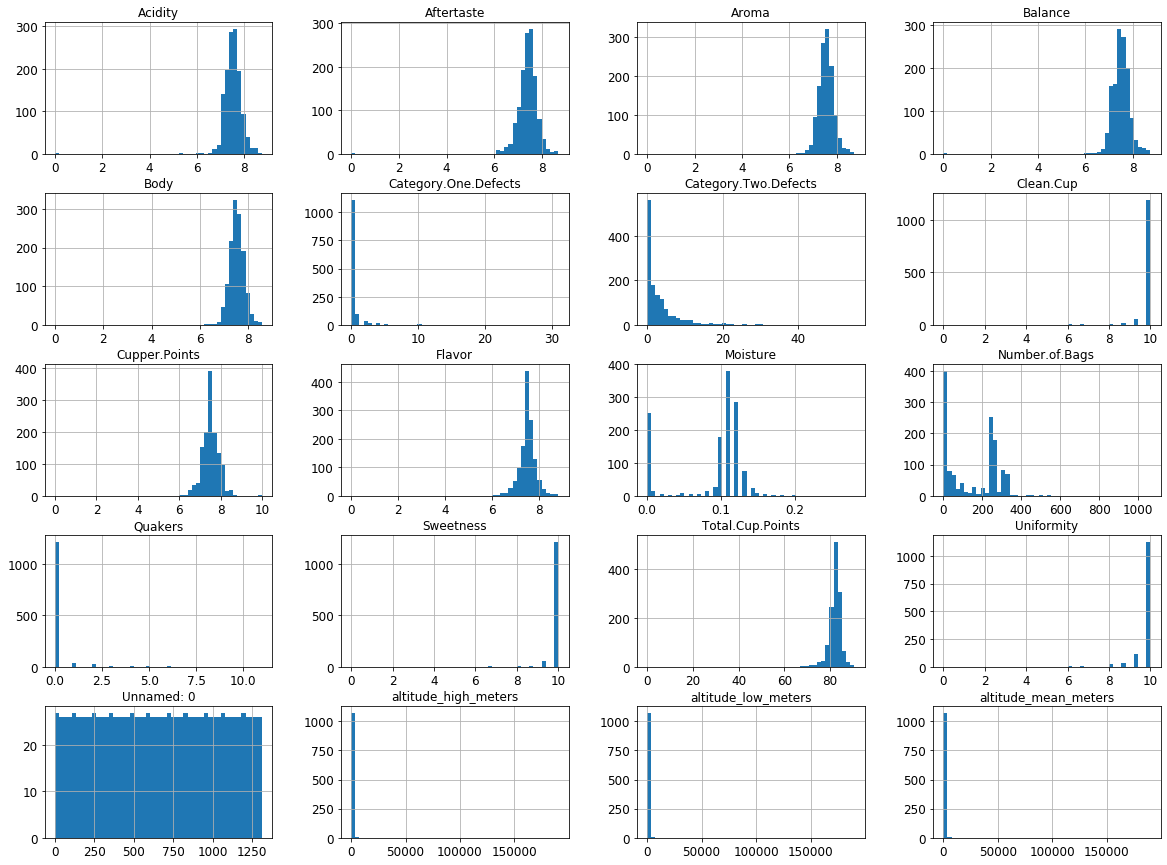

In [15]:
coffee.hist(bins=50,figsize=(20,15))
plt.show()